Advanced Lane Finding

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import math
import os
from moviepy.editor import VideoFileClip, clips_array, vfx
from IPython.display import HTML
%matplotlib qt
%matplotlib inline


In [3]:
def get_3d_to_2d_mapping():
    images = glob.glob('camera_cal/calibration*.jpg')

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
            #write_name = 'camera_cal_corners_marked/corners_found'+str(idx+1)+'.jpg'
            # Send over image, object points, image points, and image size to get undistorted
    return objpoints, imgpoints

In [4]:
objpoints, imgpoints = get_3d_to_2d_mapping()

In [5]:
def calibrate_camera(test_img_path):
    # Run calibration
    img = mpimg.imread(test_img_path)
    img_size = (img.shape[1], img.shape[0])
    # Camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('output_images/chessboard_undist.jpg',dst)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#     dist_pickle = {}
#     dist_pickle["mtx"] = mtx
#     dist_pickle["dist"] = dist
#     pickle.dump( dist_pickle, open("camera_cal/image_dist_pickle.p", "wb" ))
    #img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    """ Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    """
    return mtx, dist

def undistort_image(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [6]:
#let's calibrate camera to find camera matrix and distortion
mtx, dist = calibrate_camera("camera_cal/calibration1.jpg")

In [20]:
def main(img):
    initial_img = np.copy(img)
    img = np.copy(img)
    """ Calibrate Camera """
    #camera_calibrate()
    """ Undistort """
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
#     dist_pickle = pickle.load( open( "camera_cal/image_dist_pickle.p", "rb" ) )
#     mtx = dist_pickle["mtx"]
#     dist = dist_pickle["dist"]
    # Pass in images/video through main() to get undistorted image/video
    undist = undistort_image(img,mtx,dist)
    """ Thresholds """
    thresh, color_thresh = thresholds(undist)
    """ Perspective Transform """
    # Image perspective change, view=1 will change to birds-eye-view, view=0 will change to original
    transform = perspective(thresh, view=1) #threshold view
    transform2 = perspective(undist, view=1) #street view
    
    """ Finding Lane Lines """
    search,lane_fill,left_fitx,right_fitx,ploty,left_curverad_real,right_curverad_real,distance_l,distance_r = fit_polynomial(transform)
    """ Perspective Transform """
    
    # Returning the iamge back to original perspective
    forward_view = perspective(search, view=0)
    forward_lane_fill = perspective(lane_fill, view=0)
    """ Marking Up Lane """
    lane_fill = weighted_img(forward_lane_fill, undist)
    lane_markup = weighted_img(forward_view, lane_fill)
    """ Adding Calculations to Images """
    curvature = abs((min(left_curverad_real,right_curverad_real))/1000)
    
    curvature_str = 'Radius of Curvature: %d km' % round(curvature,2)
    
    distance = (((distance_r - distance_l)/2) - img.shape[1]*.5)/10 * (3.7/700)
    if distance > 0.1:
        direction = ' to the right'
    elif distance < -0.1:
        direction = ' to the left'
    else:
        direction = ''
    dist_center = 'Distance from Center: {} m{}'
    offset_str = dist_center.format(abs(round(distance,2)),direction)
    
    cv2.putText(lane_markup, curvature_str, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,20,20), 3, cv2.LINE_AA)
    cv2.putText(lane_markup, offset_str, (100,180), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,20,20), 3, cv2.LINE_AA)

    
    # For use as Pipeline
    return lane_markup
    
    # For testing purposes
    # Visualizing difference
    """f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(lane_final)
    ax2.set_title('Lane Markup Final Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)"""

In [34]:
def thresholds(img,s_thresh=(160,255),l_thresh=(190,255),v_thresh=(200,255),sx_thresh=(60,100),
               mag_thresh=(100,255),dir_thresh=(0.7,1.3),sobel_kernel=5):
    img = np.copy(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #convert to hls to use l and s
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #convert to hls to use l and s
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hls[:,:,2]
    # Sobel derivative, absolute derivative, and scaled sobel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold magnitude of gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    gradmag_binary = np.zeros_like(gradmag)
    gradmag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Threshold direction gradient
    dirgrad = np.arctan2(abs_sobely, abs_sobelx)
    dirgrad_binary = np.zeros_like(dirgrad)
    dirgrad_binary[(dirgrad >= dir_thresh[0]) & (dirgrad <= dir_thresh[1])] = 1
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Stack each channel: options sxbinary, gradmag_binary, dirgrad_binary, s_binary, l_binary, and v_binary
    color_binary = np.dstack((gradmag_binary, l_binary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(gradmag_binary == 1) | (l_binary == 1) | (s_binary == 1)] = 1
    combined_bin = region_of_interest(combined_binary)
    color_bin = region_of_interest(color_binary)
    return combined_bin, color_bin

def region_of_interest(img):
    xlength = img.shape[1]
    ylength = img.shape[0]
    ignore_mask_color = [255, 255, 255] 
    
    # Clear outside and inside of lane
    vertices = np.array([[(xlength*.1,ylength),(xlength*.45, ylength*.5), (xlength*.55, ylength*.5), (xlength*.9,ylength),
                          (xlength*.8,ylength),(xlength*.52, ylength*.75),(xlength*.48, ylength*.75),(xlength*.2,ylength)]], dtype=np.int32)
    mask = np.zeros_like(img)   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
            
def perspective(img, view=1):
    # Warp your image to a top-down view or original perspective
    offset = 450 # offset for dst points
    # src points
    src = np.float32([(img.shape[1]*.32,img.shape[0]),(img.shape[1]*.47,img.shape[0]*.65),
                      (img.shape[1]*.53,img.shape[0]*.65),(img.shape[1]*.68,img.shape[0])])
    # dst points
    dst = np.float32([[offset,img.shape[0]],[offset,img.shape[0]*0],
                      [img.shape[1]-offset, img.shape[0]*0],[img.shape[1]-offset,img.shape[0]]])
    # Get M, the transform matrix
    if view==1:
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    elif view==0:
        M = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return warped

def fit_polynomial(img):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, distance_l, distance_r = find_lane_pixels(img)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    # Fit a second order polynomial to each array
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # For meter calculations
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Utilize `ym_per_pix` & `xm_per_pix` here
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    left_curverad_real, right_curverad_real = measure_curvature_pixels(ploty,left_fit_cr,right_fit_cr)
    #left_curverad_real, right_curverad_real = measure_curvature_meters(ploty,left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
    """# Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')"""
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the lane area
    width=480
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))]) #left_fitx-margin
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+width,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))]) #right_fitx+margin
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,50,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,50,0))
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    return out_img,window_img,left_fitx,right_fitx,ploty,left_curverad_real,right_curverad_real,distance_l,distance_r

def find_lane_pixels(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img,img,img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    distance_l = midpoint - leftx_base
    distance_r = rightx_base - midpoint
    # HYPERPARAMETERS
    nwindows = 9 # Choose the number of sliding windows
    margin = 20 # Set the width of the windows +/- margin
    minpix = 50 # Set minimum number of pixels found to recenter window
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        # Boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),(0,0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),(0,0,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, distance_l, distance_r

def measure_curvature_pixels(ploty,left_fit,right_fit):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_curvature_meters(ploty,left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix):
    # Define y-value where we want radius of curvature
    # Maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Calculation of R_curve (radius of curvature)
    left_curverad_real = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_real = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad_real, right_curverad_real

def weighted_img(img, initial_img, α=1., β=.8, γ=0.):
    # Enter overlay and original
    return cv2.addWeighted(initial_img, α, img, β, γ)


#img = mpimg.imread('test_images/shadow_test3.jpg')
#images = glob.glob('test_images/test*.jpg')
#for idx, test in enumerate(images):
    #img = mpimg.imread(test)
    
#image = np.array(main(img))
#plt.imshow(image)


# Video to frames processing
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    result = main(image)
    # you should return the final output (image where lines are drawn on lanes)
#     np.array(result)
    return result

In [35]:
def test_lane_detection():
    # Make a list of calibration images
    images = glob.glob("test_images/*.jpg")
    for fname in images:
        img = mpimg.imread(fname)
        
        result = process_image(img)
        plt.figure()
        plt.imshow(result)

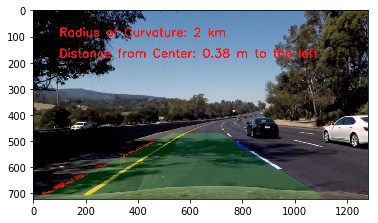

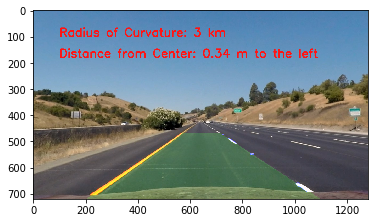

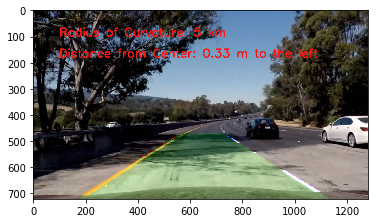

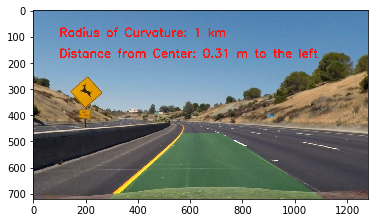

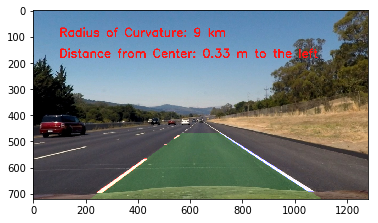

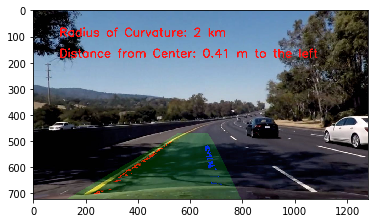

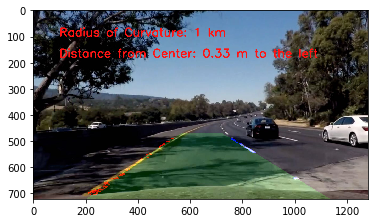

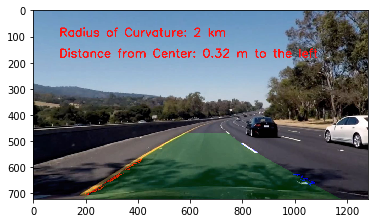

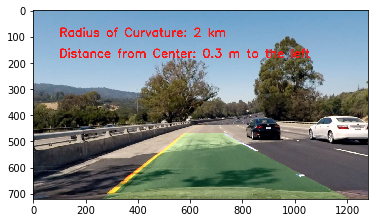

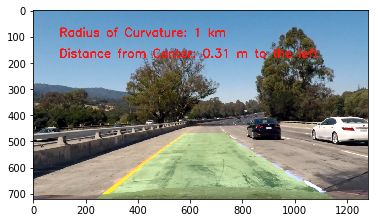

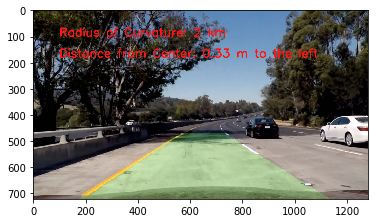

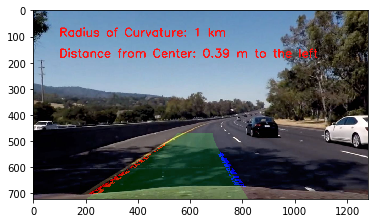

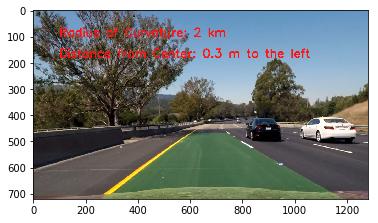

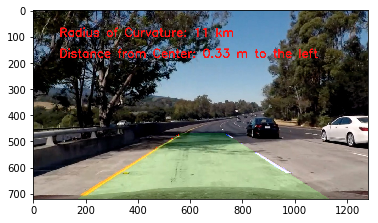

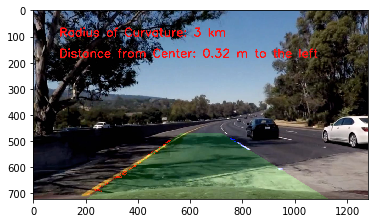

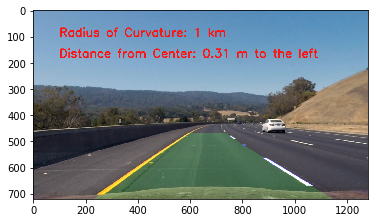

In [36]:
test_lane_detection()

In [37]:
# Video to frames
video_test = 'output_videos/challenge_video_output1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(38,43)
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(video_test, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_output1.mp4
[MoviePy] Writing video output_videos/challenge_video_output1.mp4



 27%|██▋       | 133/485 [00:34<01:38,  3.59it/s]

TypeError: expected non-empty vector for x